In [1]:
# boilerplate cell for stuff that comes out of the box with R, probably
# copied from https://github.com/Azure/RNNForTimeSeriesForecasting, because I am new to this stuff
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_process import arma_generate_sample as arimasim
from statsmodels.tsa.ar_model import AR, ARResults
from glob import glob
from collections import UserDict
from IPython.display import Image, Markdown, display
from utils import Capturing, pcorr, acf_df
%matplotlib inline

# some kind soul ported a bunch of default R datasets (and more) into python, bless his soul
from pydataset import data as pdsd

pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

Original:
```R
library(astsa)
my.data=rec

# Plot rec 
plot(rec, main='Recruitment time series', col='blue', lwd=3)
```

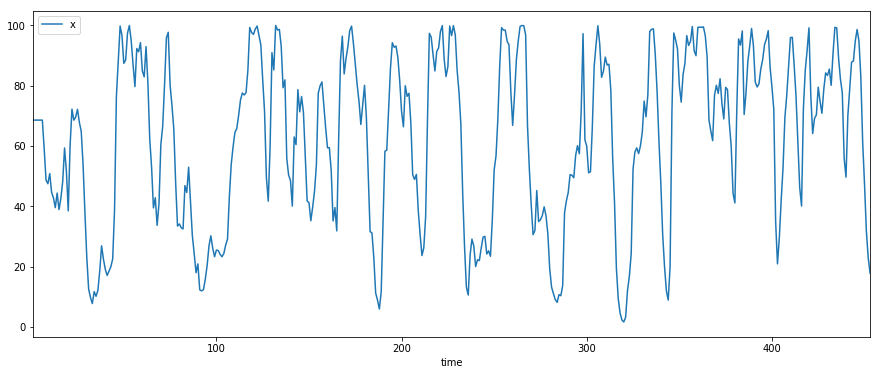

In [2]:
df = pd.read_csv("rec.csv")
df.rename(columns={"Unnamed: 0":"time"},inplace=True)
df.plot(x="time",y="x",figsize=[15,6])

Original:
```R
# subtract mean to get a time series with mean zero
ar.process=my.data-mean(my.data)

# ACF and PACF of the process
par(mfrow=c(2,1))
acf(ar.process, main='Recruitment', col='red', lwd=3)
pacf(ar.process, main='Recruitment', col='green', lwd=3)
```

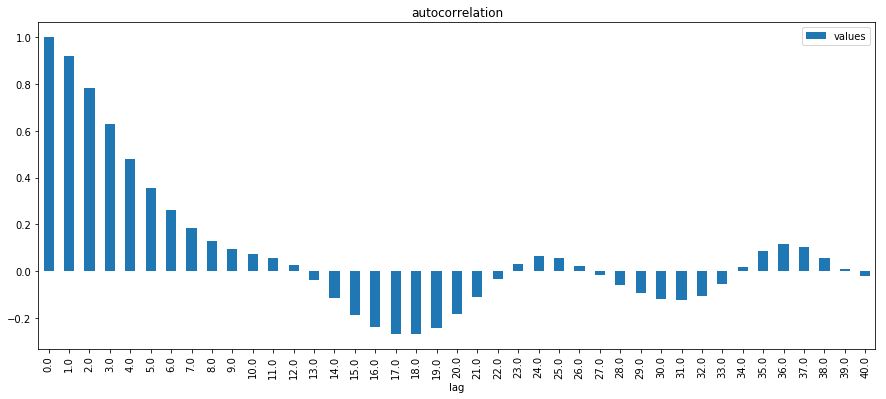

In [5]:
df['process'] = df['x'] - df['x'].mean()
acf_df(df['process']).plot(x="lag",y="values",kind="bar",figsize=[15,6],title="autocorrelation")

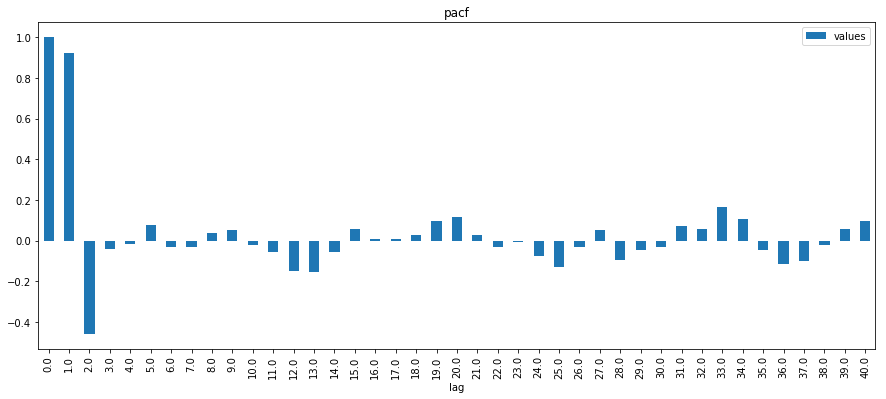

In [6]:
acf_df(df['process'],mode="pacf").plot(x="lag",y="values",kind="bar",figsize=[15,6],title="pacf")

Original:
```R
# order
p=2

# sample autocorreleation function r
r=NULL
r[1:p]=acf(ar.process, plot=F)$acf[2:(p+1)]
cat('r=',r,'\n')
```

In [33]:
p = 2
r = sts.acf(df['process'])[1:p+1]

Original:
```R
# matrix R
R=matrix(1,p,p) # matrix of dimension 2 by 2, with entries all 1's.

# define non-diagonal entires of R
for(i in 1:p){
	for(j in 1:p){
		if(i!=j)
			R[i,j]=r[abs(i-j)]
		}
	}
R
```

In [10]:
R = np.ones((p,p))
for i in range(p):
    for j in range(p):
        if i!=j:
            R[i,j] = r[abs(i-j)-1]

R

array([[1.    , 0.9218],
       [0.9218, 1.    ]])

In [22]:
b = r.T
b
# transposing a 1d array doesn't seem to change anything in numpy

array([0.9218, 0.7829])

Original:
```R
# solve(R,b) solves Rx=b, and gives x=R^(-1)b vector
phi.hat=NULL
phi.hat=solve(R,b)[,1]
phi.hat
```

In [23]:
phihat = np.linalg.solve(R,b)
phihat

array([ 1.3316, -0.4445])

Original:
```R
#variance estimation using Yule-Walker Estimator
c0=acf(ar.process, type='covariance', plot=F)$acf[1]
c0
```

In [27]:
c0 = sts.acovf(df['process'])[0]
c0

780.9909777969335

Original:
```R
var.hat=c0*(1-sum(phi.hat*r))
var.hat
```

In [28]:
varhat = c0*(1-(phihat*r).sum())
varhat

94.17131010772871

Original:
```R
# constant term in the model
phi0.hat=mean(my.data)*(1-sum(phi.hat))
phi0.hat
```

In [29]:
phi0hat = df['x'].mean() * (1-phihat.sum())
phi0hat

7.033036267085922

Original:
```R
cat("Constant:", phi0.hat," Coeffcinets:", phi.hat, " and Variance:", var.hat, '\n')
```

In [32]:
print("Constant: %.4f, Coefficients: %s and Variance: %.4f" % (phi0hat, phihat, varhat))

Constant: 7.0330, Coefficients: [ 1.3316 -0.4445] and Variance: 94.1713
